In [1]:
import tensorflow as tf
import numpy as np

In [2]:
def haar1d(x, axis, concat_axis=None):
    xshape = tf.shape(x)
    xndim = len(x.get_shape())
    new_shape = tf.concat(0, (xshape[:axis], tf.pack((xshape[axis] // 2, tf.constant(2))), xshape[axis + 1:]))
    perm = tf.concat(0, (tf.pack((axis + 1,)),  tf.range(0, axis + 1), tf.range(axis + 2, xndim + 1)))
    reorganized = tf.transpose(tf.reshape(x, new_shape), perm)
    even, odd = tf.split(0, 2, reorganized)
    diff = (odd - even) / tf.constant(np.sqrt(2.), dtype=tf.float32)
    summ = (odd + even) / tf.constant(np.sqrt(2.), dtype=tf.float32)
    if concat_axis is None:  # if no axis specified, add one at the beginning
        concat_axis = 0
    else:  # the split leaves an artificial first axis that we need to remove
        # Can't just do diff, summ = diff[0], summ[0] because this stupid shit framework needs the full slice
        # so we have to specify the shape and reshape accordingly
        diff, summ = tf.reshape(diff, tf.shape(diff)[1:]), tf.reshape(summ, tf.shape(summ)[1:])
    concat = tf.concat(concat_axis, (diff, summ))
    #output_shape = tf.concat(0, (tf.pack((2,)), xshape[:axis], tf.pack((xshape[axis] // 2,)), xshape[axis + 1:]))
    return concat #tf.reshape(concat, output_shape)

In [3]:
def haar(x, axes, concat_axis=None):
    
    if concat_axis is None:
        # then add an axis at the end, recall the function and concatenate on that one
        xshape = tf.shape(x)
        xshape1 = tf.concat(0, (xshape, tf.pack((1,))))
        concat_axis = tf.shape(xshape1)[0] - 1
        return haar(tf.reshape(x, xshape1), axes, concat_axis)
    
    result = x
    for axis in axes:
        result = haar1d(result, axis, concat_axis)
    return result

In [4]:
a = tf.placeholder(tf.float32, shape=(1, 512, 512))
len(a.get_shape())
sess = tf.Session()
c = haar1d(a, 2)
print(c.get_shape())
d = haar1d(c, 2)
e = haar(a, (1, 2))
r = sess.run(d, {a: np.arange(512 ** 2, dtype='float32').reshape((1, 512, 512))})
cc = haar1d(a, 2, concat_axis=2)
rr = sess.run(cc, {a: np.arange(512 ** 2, dtype='float32').reshape((1, 512, 512))})
re = sess.run(e, {a: np.arange(512 ** 2, dtype='float32').reshape((1, 512, 512))})
sess.close()
r.shape, rr.shape, re.shape

(?, ?, ?, ?)


((2, 2, 1, 256, 256), (1, 512, 512), (1, 256, 256, 4))

In [5]:
from skimage.data import coffee

In [6]:
cof = coffee().mean(2).astype('float32')
cof.shape

(400, 600)

In [7]:
a = tf.placeholder(tf.float32, shape=(400, 600))

sess = tf.Session()
c = haar1d(a, 1)
print(c.get_shape())
d = haar1d(c, 1)
dd = haar(a, (0, 1))
ddd = haar(dd, (0, 1, 2))
dddd = haar(ddd, (0, 1, 2, 3))
r = sess.run(d, {a: cof})
rr = sess.run(dd, {a: cof})
rrr = sess.run(ddd, {a: cof})
rrrr = sess.run(dddd, {a: cof})
sess.close()
r.shape, rr.shape, rrr.shape, rrrr.shape


(?, ?, ?)


((2, 2, 200, 300), (200, 300, 4), (100, 150, 2, 8), (50, 75, 1, 4, 16))

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

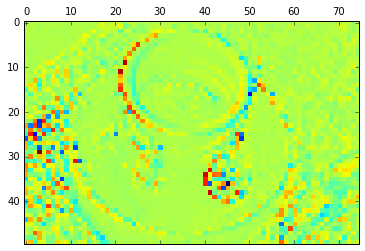

In [9]:
plt.matshow(rrrr[:, :, 0, 2, 15])


In [10]:
#plt.imshow(r)

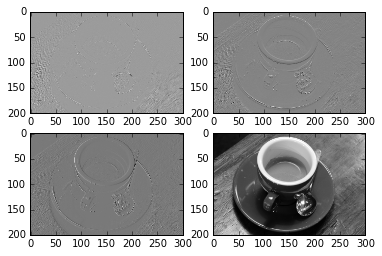

In [11]:
counter = 0
for row in r:
    for col in row:
        counter += 1
        plt.subplot(2, 2, counter)
        plt.imshow((col))
        plt.gray()

In [12]:
# def nd1dconv(images, fil_matrix):
#     images_shape = tf.shape(images)   # can't use symbolic shape -- too fucked up --- but have to use it
#     images_shape_ = images.get_shape()
#     images1 = tf.reshape(images, tf.concat(0, (images_shape, tf.pack((1,)) ) ))
#     fil_padded = tf.reshape(fil_matrix, tf.concat(0, (tf.ones_like(images_shape)[1:], tf.shape(fil_matrix) ) ))
    
#     # batch_matmul forces us to tile because the stupid shit doesn't broadcast
#     # we also can't do images_shape[:-1], so we have to truncate it explicitely
#     truncated_images_shape = images_shape[:len(images_shape_) - 1]
#     tile_multiples = tf.concat(0, (truncated_images_shape, tf.pack((1, 1))))
#     fil_padded_tiled = tf.tile(fil_padded, tile_multiples)
#     multiplied = tf.batch_matmul(fil_padded_tiled, images1)
#     return multiplied

In [13]:
def nd1dconv(images, fil_matrix):
    # because batch_matmul doesn't broadcast, we need tile
    # because tile doesn't do high dim, we are fucked and have to reshape
    # So we may as well use 1x1 convolution
    images_shape = tf.shape(images)
    images_ndim = len(images.get_shape())
    
    images_processing_shape = tf.concat(0, (images_shape[:2], tf.pack((-1, images_shape[images_ndim - 1]))))
    images_reshaped = tf.reshape(images, images_processing_shape)
    
    filters_shape = tf.concat(0, (tf.pack((1, 1)), tf.shape(fil_matrix)))
    filters_reshaped = tf.reshape(fil_matrix, filters_shape)
    
    conv_output = tf.nn.conv2d(images_reshaped, filters_reshaped, (1, 1, 1, 1), 'SAME')
    
    output_shape = tf.concat(0, (images_shape[:images_ndim - 1], tf.pack((tf.shape(fil_matrix)[1], ))))
    
    return tf.reshape(conv_output, output_shape)

In [14]:
images = tf.placeholder(tf.float32, (None, 5, 6, 10, 10, 4))
fil_matrix = tf.placeholder(tf.float32, (4, 7))
multiplied = nd1dconv(images, fil_matrix)

sess = tf.Session()
r = sess.run(multiplied, {images: np.arange(2 * 5 * 6 * 10 * 10 * 4).reshape(2, 5, 6, 10, 10, 4), fil_matrix :np.arange(28).reshape(4, 7)})

sess.close()
r.shape

(2, 5, 6, 10, 10, 7)

In [15]:
def haar_and_1x1(x, ):
    pass

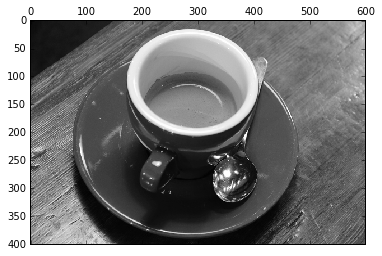

In [16]:
plt.matshow(cof)

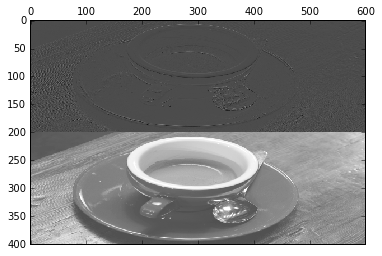

In [17]:
reshaped = np.rollaxis(cof.reshape(200, 2, 600), 1)
even, odd = reshaped
diff, summ = (odd - even) / np.sqrt(2), (odd + even) / np.sqrt(2)
haar = np.concatenate((diff, summ), axis=0)
plt.matshow(haar)

In [18]:
from haar import haar_and_1x1

In [19]:
inp = tf.placeholder(tf.float32, (1, 400, 600))
h1 = haar_and_1x1(inp, 8, 'h1')
h2 = haar_and_1x1(h1, 8, 'h2')

In [20]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
rh1 = sess.run(h1, {inp: cof[np.newaxis]})
rh2 = sess.run(h2, {inp: cof[np.newaxis]})
sess.close()
rh1.shape, rh2.shape

((1, 200, 300, 8), (1, 100, 150, 4, 8))

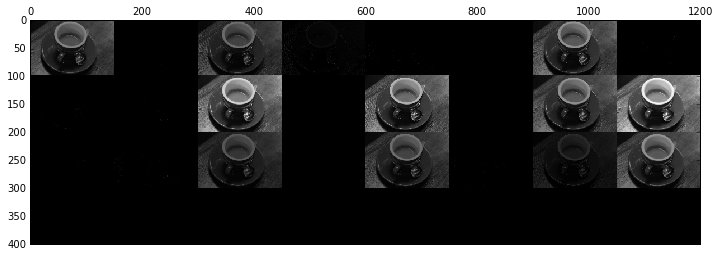

In [25]:
#plt.matshow(rh1.transpose(3, 0, 1, 2).reshape(1600, 300))
plt.matshow(rh2.transpose(3, 1, 4, 2, 0).reshape(400, 1200))

In [23]:
tf.get_variable?